#### **Phase I**

#### 1. Problem & Target

|Columns|Descriptions|
|---|---|
|UTC|Timestamp UTC seconds|
|Temperature[C]|Air Temperature|
|Humidity[%]|Air Humidity|
|TVOC[ppb]|otal Volatile Organic Compounds; measured in parts per billion|
|eCO2[ppm]|co2 equivalent concentration; calculated from different values like TVCO|
|Raw H2|raw molecular hydrogen; not compensated (Bias, temperature, etc.)|
|Raw Ethanol|raw ethanol gas|
|Pressure[hPa]|Air Pressure|
|PM1.0|particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)|
|PM2.5|particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)|
|NC0.5|Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5)|
|NC1.0|Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5)|
|NC2.5|Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5)|
|CNT|Sample counter|
|Fire Alarm|ground truth is "1" if a fire is there|

#### 2. dataset

In [1]:
## load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from my_template import tot_exec_time, added_section_separate_line, remove_column, describe_skew_unvariate_distribution, describe_class_distribution
from my_template import visualize_features_hist, visualize_density_plot, visualize_box_whisker_plot, visualize_correlation_matrix
from my_template import detect_column_only_single_value, detect_column_very_few_value, detect_have_null_value, detect_outlier_over3std, detect_outlier_quartile
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [2]:
## load dataset
df = pd.read_csv('./dataset/smoke_detection_iot.csv', index_col=0)
col_rename_dict = {
    'Temperature[C]': 'temp',
    'Humidity[%]': 'humid',
    'TVOC[ppb]': 'tvoc',
    'eCO2[ppm]': 'eCO2',
    'Raw H2': 'raw_H2',
    'Raw Ethanol': 'raw_ethanol',
    'Pressure[hPa]': 'pressure',
    'CNT': 'cnt',
    'Fire Alarm': 'fire_alarm'
}
df.rename(columns=col_rename_dict, inplace=True)
print(df.shape)
print(df.head())

(62630, 15)
          UTC    temp  humid  tvoc  eCO2  raw_H2  raw_ethanol  pressure  \
0  1654733331  20.000  57.36     0   400   12306        18520   939.735   
1  1654733332  20.015  56.67     0   400   12345        18651   939.744   
2  1654733333  20.029  55.96     0   400   12374        18764   939.738   
3  1654733334  20.044  55.28     0   400   12390        18849   939.736   
4  1654733335  20.059  54.69     0   400   12403        18921   939.744   

   PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  cnt  fire_alarm  
0    0.0    0.0    0.0    0.0    0.0    0           0  
1    0.0    0.0    0.0    0.0    0.0    1           0  
2    0.0    0.0    0.0    0.0    0.0    2           0  
3    0.0    0.0    0.0    0.0    0.0    3           0  
4    0.0    0.0    0.0    0.0    0.0    4           0  


In [3]:
## summarize data
print(f"dataset head: \n{df.head()}")
added_section_separate_line()
print(f"dataset shape: {df.shape}")
added_section_separate_line()
pd.set_option('precision', 1)
print(f"dataset description: \n{df.describe()}")
added_section_separate_line()
print("feaures skew:")
describe_skew_unvariate_distribution(df, df.columns)
added_section_separate_line()
print("target class distribution:")
describe_class_distribution(df, 'fire_alarm')

dataset head: 
          UTC    temp  humid  tvoc  eCO2  raw_H2  raw_ethanol  pressure  \
0  1654733331  20.000  57.36     0   400   12306        18520   939.735   
1  1654733332  20.015  56.67     0   400   12345        18651   939.744   
2  1654733333  20.029  55.96     0   400   12374        18764   939.738   
3  1654733334  20.044  55.28     0   400   12390        18849   939.736   
4  1654733335  20.059  54.69     0   400   12403        18921   939.744   

   PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  cnt  fire_alarm  
0    0.0    0.0    0.0    0.0    0.0    0           0  
1    0.0    0.0    0.0    0.0    0.0    1           0  
2    0.0    0.0    0.0    0.0    0.0    2           0  
3    0.0    0.0    0.0    0.0    0.0    3           0  
4    0.0    0.0    0.0    0.0    0.0    4           0  
------------------------------
dataset shape: (62630, 15)
------------------------------
dataset description: 
           UTC     temp    humid     tvoc     eCO2   raw_H2  raw_ethanol  \
count  6.3e

fire_alarm
0    17873
1    44757
dtype: int64

Histogram of features:


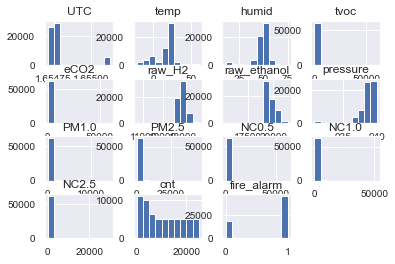

------------------------------
Density Plots of features:


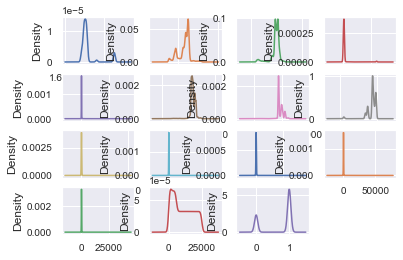

------------------------------
Box-whisker Plots of features:


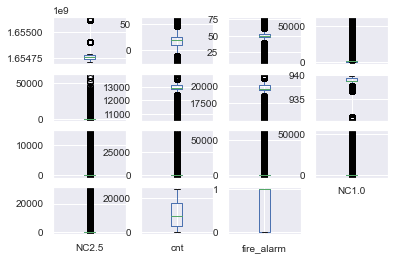

------------------------------
Correlation matrix of features:


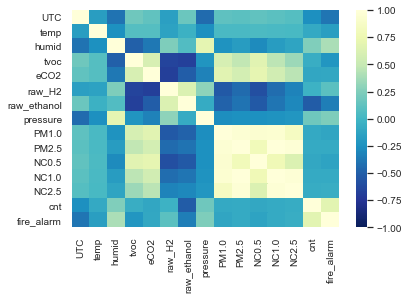

In [4]:
## data visualization
sns.set_theme(style="darkgrid")
plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)
visualize_features_hist(df, df.columns)
added_section_separate_line()
visualize_density_plot(df, df.columns, layout=(4,4), legend=False)
added_section_separate_line()
visualize_box_whisker_plot(df, df.columns, layout=(4,4), legend=False)
added_section_separate_line()
visualize_correlation_matrix(df, df.columns, annot=False)

* 小結：
    * UTC作為時間戳記，並非一個好的feature，考慮刪除
    * tvoc, PM1.0, PM2.5, NC0.5, NC1.0, NC2.5, cnt的最小值皆為0，後續確認missing value時需考慮是否有以0替代的情形
    * Target(fire_alarm)為binary classification，其fire_alarm=1所占比例為71.4%，需考慮是否有imbalanced class的問題
    * PM1.0, PM2.5, NC0.5, NC1.0, NC2.5數值範圍與其他如tvoc, eCO2或raw_H2等features不同，需考慮做re-scaling

#### **Phase II** (Round 0)

#### 3. data preprocessing

In [4]:
# remove column UTC
col_list = ['UTC']
df = remove_column(df, col_list)
print(df.head())

   temp  humid  tvoc  eCO2  raw_H2  raw_ethanol  pressure  PM1.0  PM2.5  \
0  20.0   57.4     0   400   12306        18520     939.7    0.0    0.0   
1  20.0   56.7     0   400   12345        18651     939.7    0.0    0.0   
2  20.0   56.0     0   400   12374        18764     939.7    0.0    0.0   
3  20.0   55.3     0   400   12390        18849     939.7    0.0    0.0   
4  20.1   54.7     0   400   12403        18921     939.7    0.0    0.0   

   NC0.5  NC1.0  NC2.5  cnt  fire_alarm  
0    0.0    0.0    0.0    0           0  
1    0.0    0.0    0.0    1           0  
2    0.0    0.0    0.0    2           0  
3    0.0    0.0    0.0    3           0  
4    0.0    0.0    0.0    4           0  


In [5]:
## data cleaning - data detection to remove
detect_column_only_single_value(df)
added_section_separate_line()
detect_column_very_few_value(df)
added_section_separate_line()
detect_have_null_value(df)
added_section_separate_line()
for col in df.columns[:-1]:
    print(f"Feature ({col}):", end=" ")
    detect_outlier_over3std(df, col)
added_section_separate_line()
for col in df.columns[:-1]:
    print(f"Feature ({col}):", end=" ")
    detect_outlier_quartile(df, col)

Record columns to delete (only single value): []
------------------------------
Record columns to delete (very few value): [13]
------------------------------
There is no null value in dataframe.
------------------------------
Feature (temp): Identified outliers: 62, Non-outlier observation: 62630
Feature (humid): Identified outliers: 2772, Non-outlier observation: 62630
Feature (tvoc): Identified outliers: 1270, Non-outlier observation: 62630
Feature (eCO2): Identified outliers: 762, Non-outlier observation: 62630
Feature (raw_H2): Identified outliers: 996, Non-outlier observation: 62630
Feature (raw_ethanol): Identified outliers: 838, Non-outlier observation: 62630
Feature (pressure): Identified outliers: 1154, Non-outlier observation: 62630
Feature (PM1.0): Identified outliers: 692, Non-outlier observation: 62630
Feature (PM2.5): Identified outliers: 584, Non-outlier observation: 62630
Feature (NC0.5): Identified outliers: 773, Non-outlier observation: 62630
Feature (NC1.0): Identif

#### 4. model & validation

In [43]:
seed = 87
scoring = 'accuracy'
num_folds = 10

In [44]:
data = df.values
X = data[:, :-1].astype(float)
y = data[:, -1].astype(str)
validation_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [45]:
# build model
models = dict()
models['LR'] = Pipeline(steps=[('m', LogisticRegression(solver='liblinear'))])
models['LDA'] = Pipeline(steps=[('m', LinearDiscriminantAnalysis())])
models['KNN'] = Pipeline(steps=[('m', KNeighborsClassifier())])
models['CART'] = Pipeline(steps=[('m', DecisionTreeClassifier())])
models['NB'] = Pipeline(steps=[ ('m', GaussianNB())])
#models['SVM'] = Pipeline(steps=[('m', SVC(gamma='auto'))])
#models['RF'] = Pipeline(steps=[('m', RandomForestClassifier())])
#models['GBM'] = Pipeline(steps=[('m', GradientBoostingClassifier())])
# train model
results, names = list(), list()
for name, model in models.items():
    cv = KFold(n_splits=10, random_state=seed, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    results.append(scores)
    names.append(name)
    print(f">{name} {np.mean(scores):.3f} ({np.std(scores):.3f})")

>LR 0.979 (0.005)
>LDA 0.931 (0.006)
>KNN 1.000 (0.000)
>CART 1.000 (0.000)
>NB 0.796 (0.008)


#### **Phase III**

#### 5. prediction

In [9]:
## 使用base-model進行預測
print("# Baseline model:")
output_values = df['fire_alarm'].values.tolist()
prediction = max(set(output_values), key=output_values.count)   # 找出比例最大的分類，直接作為所有驗證集的baseline預測結果
print(f"The most common value in target: {prediction}; and ratio of this feature in all dataset: {100*len(df[df['fire_alarm']==prediction])/len(df):.2f}%")

# Baseline model:
The most common value in target: 1; and ratio of this feature in all dataset: 71.46%


In [46]:
# prediction
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"> accuracy score: {100*accuracy_score(y_test, y_pred):.3f}%")
print(f"> confusion matric: \n{confusion_matrix(y_test, y_pred)}")
print(f"> classification report: \n{classification_report(y_test, y_pred)}")

> accuracy score: 99.990%
> confusion matric: 
[[ 6091     0]
 [    2 14575]]
> classification report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6091
         1.0       1.00      1.00      1.00     14577

    accuracy                           1.00     20668
   macro avg       1.00      1.00      1.00     20668
weighted avg       1.00      1.00      1.00     20668



In [47]:
def predict_realistic_value(model, data_x, target_y):
    y_pred = model.predict(data_x)
    print(f"Compare target and prediction: target = {target_y}, prediction = {y_pred[0]}, {'predict success' if target_y==y_pred[0] else 'predict failed'}")

data_x = np.array([[2.71100e+01, 4.71200e+01, 1.14700e+03, 4.54000e+02, 1.28630e+04, 1.94390e+04, 9.38879e+02, 1.65000e+00, 1.71000e+00, 1.13600e+01, 1.77100e+00, 4.00000e-02, 1.47270e+04]])
target_y = '1.0'
predict_realistic_value(model, data_x, target_y)
added_section_separate_line()
data_x = np.array([[2.70280e+01, 4.94900e+01, 4.20000e+01, 4.00000e+02, 1.30440e+04, 1.99210e+04, 9.39781e+02, 4.00000e-01, 4.20000e-01, 2.75000e+00, 4.30000e-01, 1.00000e-02, 1.16400e+03]])
target_y = '0.0'
predict_realistic_value(model, data_x, target_y)
added_section_separate_line()
data_x = np.array([[2.06700e+01, 5.20000e+01, 3.43000e+02, 4.00000e+02, 1.30740e+04, 1.99250e+04, 9.39295e+02, 3.80000e-01, 4.00000e-01, 2.62000e+00, 4.08000e-01, 9.00000e-03, 8.83000e+03]])
target_y = '1.0'
predict_realistic_value(model, data_x, target_y)
added_section_separate_line()
data_x = np.array([[-8.81600e+00, 4.15200e+01, 7.80000e+01, 4.00000e+02, 1.27910e+04, 2.06530e+04, 9.37484e+02, 2.13000e+00, 2.22000e+00, 1.46800e+01, 2.29000e+00, 5.20000e-02, 1.35700e+03]])
target_y = '0.0'
predict_realistic_value(model, data_x, target_y)

Compare target and prediction: target = 1.0, prediction = 1.0, predict success
------------------------------
Compare target and prediction: target = 0.0, prediction = 0.0, predict success
------------------------------
Compare target and prediction: target = 1.0, prediction = 1.0, predict success
------------------------------
Compare target and prediction: target = 0.0, prediction = 0.0, predict success


* 結論：
    * 此dataset不做任何處理前，使用DecisionTreeClassifier可針對訓練&預測最佳accuracy，並比較不同train test split ratio:
        * train_set ratio = 20% -> accuracy=100%
        * train_set ratio = 33% -> accuracy=99.9%
    * 額外測試4組實際test data，預測皆成功